**Andere manier om te kijken naar evaluation, i.p.v terug te splitten en te predicten, nu opgeslagen predicition gebruiken**

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
import os
import json  # Needed for loading the mappings

# === Define path to the saved run ===
save_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3"

# ✅ Load the saved test predictions 
df = pd.read_csv(os.path.join(save_path, "test_predictions.csv"))

# ✅ Recreate logits tensor from the CSV
logits = torch.tensor(df["logits"].apply(eval).tolist())

# ✅ Apply softmax to get prediction probabilities
probabilities = F.softmax(logits, dim=1)

# ✅ Extract raw values
texts = df["text"].tolist()
true_labels_ids = df["true_label"].tolist()
predicted_label_ids = df["predicted_label"].tolist()

# ✅ Convert label IDs to themes using the mappings
with open(os.path.join(save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)

theme_to_id = mappings["theme_to_id"]
id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}  # convert keys back to int
unique_themes = mappings["unique_themes"]  # Load the unique themes list


**Unknowns**

In [2]:
# ✅ Dynamic confidence threshold
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# ✅ Predict with "Unknown" logic
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_id = torch.argmax(probabilities[i]).item()
    question = texts[i]

    if len(question.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")
    else:
        predicted_labels.append(id_to_theme[pred_id])

# ✅ Convert true labels to theme names
true_labels = [id_to_theme[i] for i in true_labels_ids]

# ✅ Compare and mark correctness
results = []
for true, pred in zip(true_labels, predicted_labels):
    if pred == "Unknown":
        results.append("Unknown")
    elif true == pred:
        results.append("Correct")
    else:
        results.append("Incorrect")

# ✅ Build output DataFrame
output_df = pd.DataFrame({
    "Text": texts,
    "True_Theme": true_labels,
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# ✅ Save it
#output_df.to_csv("evaluated_predictions.csv", index=False)



Dynamic Threshold: 0.4525


In [3]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 97 / 9686 (1.00%)


**Evaluations**

C:\Users\jefva\AppData\Local\Temp\ipykernel_21560\1732032154.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


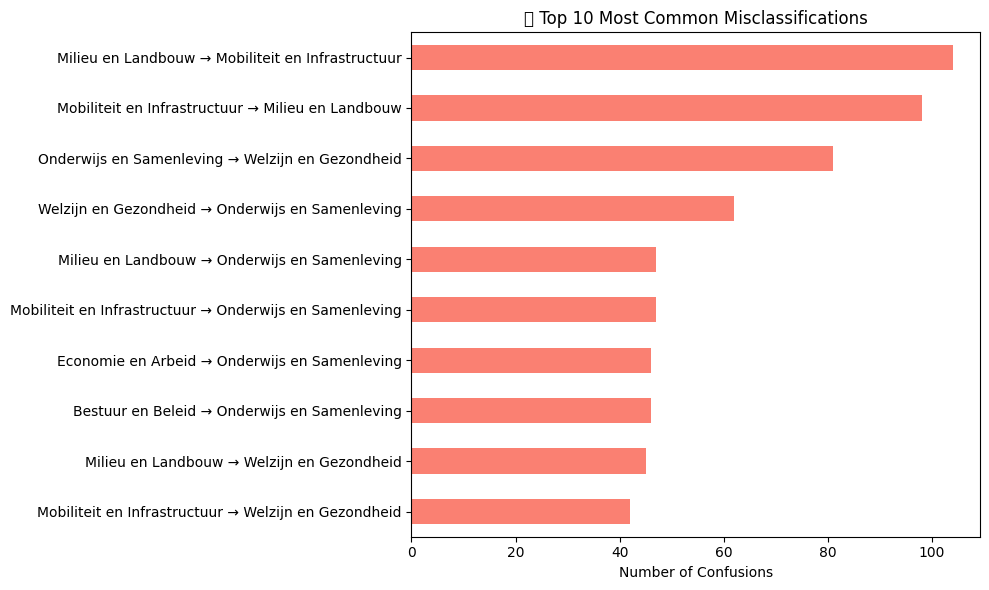

In [4]:
# ✅ Misclassification analysis (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect") &
    (output_df["Predicted_Theme"] != "Unknown")
]

top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

# ✅ Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_confusions_plot.plot(kind="barh", color="salmon")
plt.xlabel("Number of Confusions")
plt.title("🔍 Top 10 Most Common Misclassifications")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

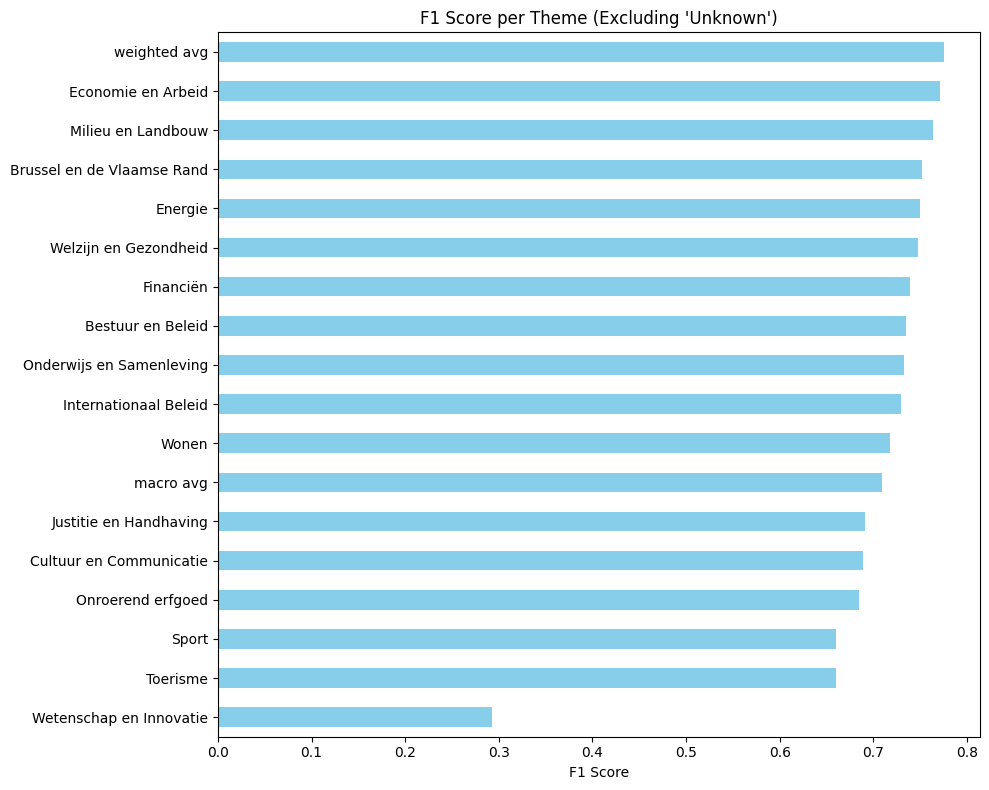

In [5]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Filter out 'Unknown' predictions for proper label matching
filtered_df = output_df[output_df["Predicted_Theme"] != "Unknown"].copy()

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(filtered_df["True_Theme"])
pred_encoded = le.transform(filtered_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme (Excluding 'Unknown')")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()

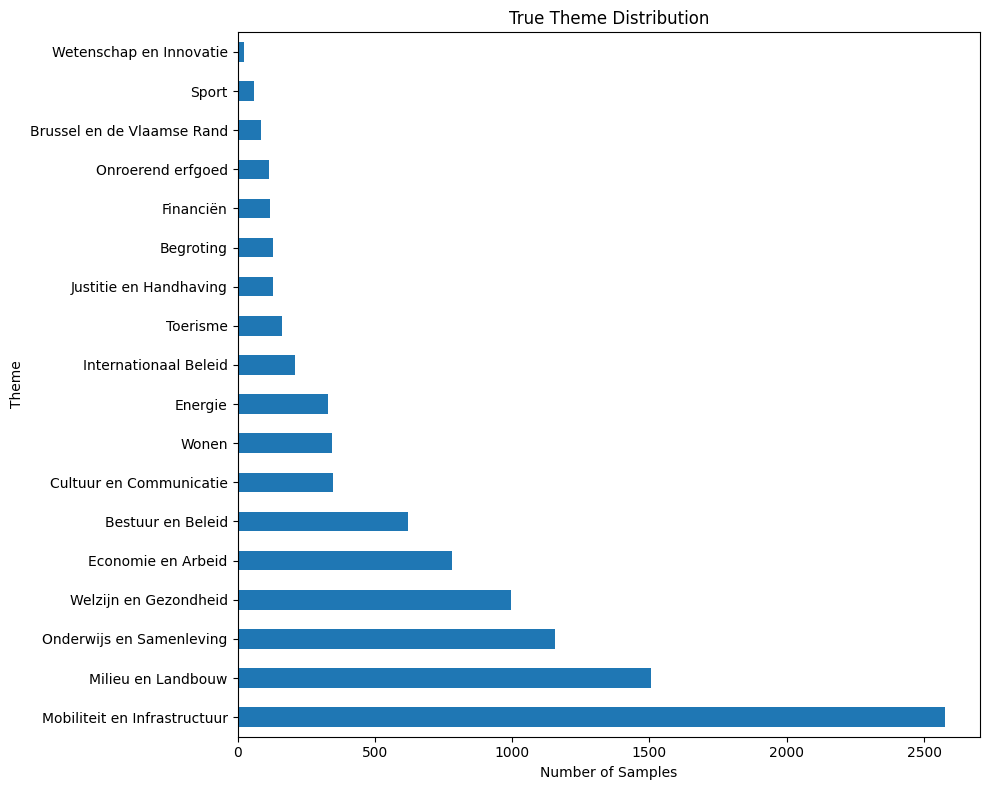

In [6]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Filter out "Unknown"
filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

# Get all unique themes used
all_labels = sorted(set(filtered_true + filtered_pred))

# ✅ Print classification report using theme names directly
print(classification_report(
    filtered_true,
    filtered_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))


                              precision    recall  f1-score   support

                   Begroting       0.79      0.76      0.78       126
           Bestuur en Beleid       0.75      0.72      0.73       617
  Brussel en de Vlaamse Rand       0.82      0.69      0.75        81
     Cultuur en Communicatie       0.73      0.65      0.69       347
          Economie en Arbeid       0.77      0.77      0.77       773
                     Energie       0.78      0.72      0.75       328
                   Financiën       0.75      0.73      0.74       116
       Internationaal Beleid       0.81      0.67      0.73       209
      Justitie en Handhaving       0.73      0.66      0.69       128
          Milieu en Landbouw       0.75      0.77      0.76      1488
Mobiliteit en Infrastructuur       0.86      0.88      0.87      2557
    Onderwijs en Samenleving       0.71      0.76      0.73      1150
           Onroerend erfgoed       0.71      0.66      0.68       113
                   

In [8]:
# ✅ Compute metrics (excluding "Unknown")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filtered_true = []
filtered_pred = []
for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true.append(true)
        filtered_pred.append(pred)

accuracy = accuracy_score(filtered_true, filtered_pred)
precision = precision_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average="weighted", zero_division=0)
f1 = f1_score(filtered_true, filtered_pred, average="weighted", zero_division=0)

print("\n📊 Evaluation (excluding 'Unknown'):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


📊 Evaluation (excluding 'Unknown'):
Accuracy:  0.7759
Precision: 0.7757
Recall:    0.7759
F1-Score:  0.7751


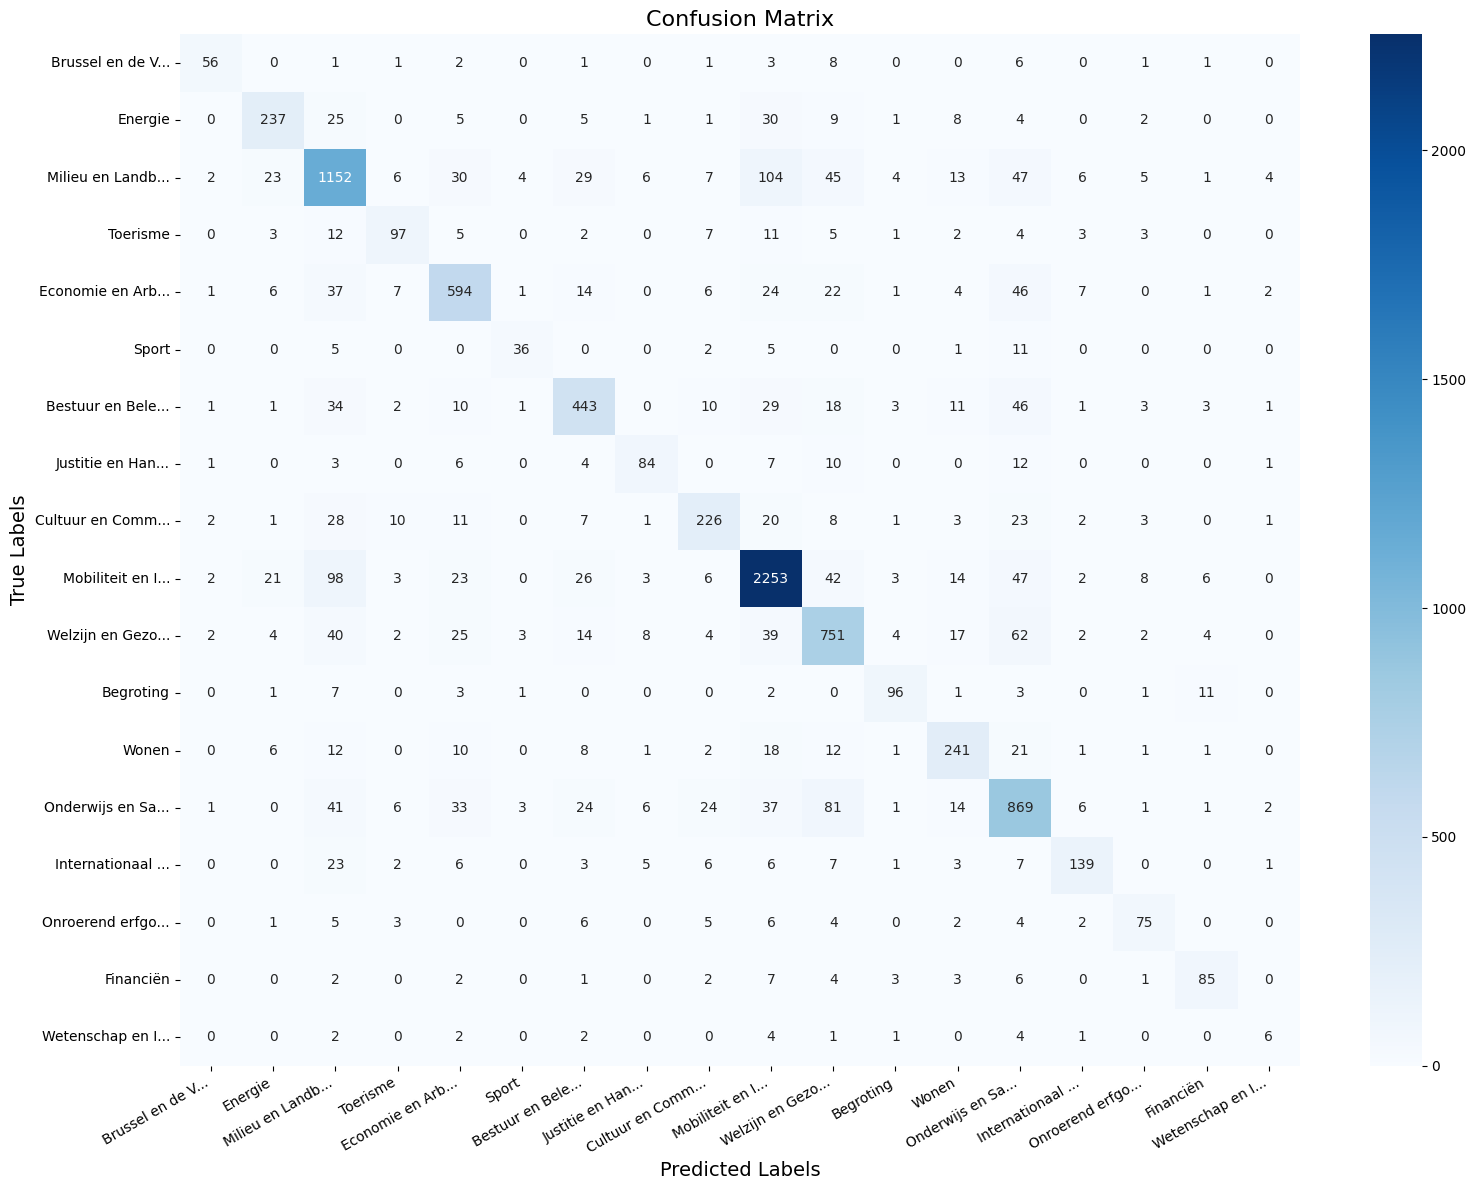

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3"
model_name = "GroNLP/bert-base-dutch-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name) 
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30073, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize and move to device
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    # Extract attention and logits
    attentions = outputs.attentions
    logits = outputs.logits

    # Get predicted class ID and name
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")

    return attentions, predicted_class_id, predicted_class_name


In [12]:
test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Milieu en Landbouw (ID: 2)
🔍 Total Attention Layers Extracted: 12


✅ Weighted ROC AUC: 0.9568


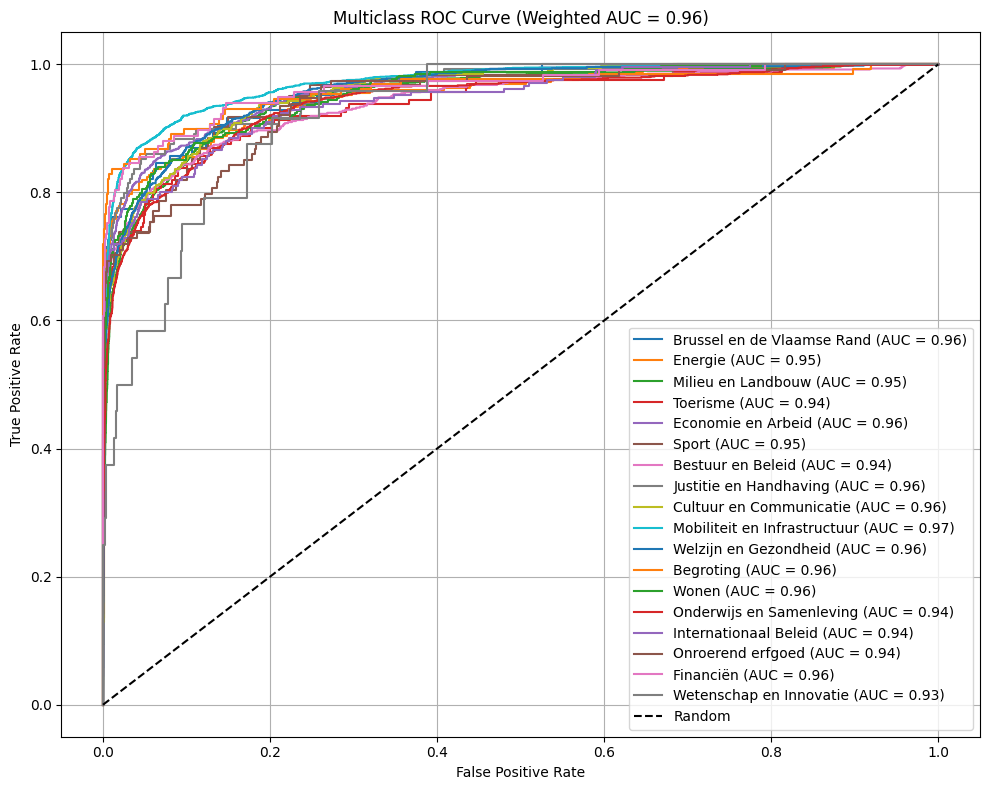

In [13]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load saved predictions
df = pd.read_csv(r"C:\Users\jefva\Documents\Master\Thesis_s2\results\groNLP\GroNLP3\GroNLP3\test_predictions.csv")

# Reconstruct logits and true labels
logits = np.array(df["logits"].apply(eval).tolist())
y_true = np.array(df["true_label"].tolist())
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
from scipy.special import softmax
y_score = softmax(logits, axis=1)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute support (number of samples per class)
support = np.bincount(y_true, minlength=n_classes)
total = support.sum()

# Compute weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"✅ Weighted ROC AUC: {weighted_auc:.4f}")

# Get real class names from mapping
class_names = [id_to_theme[i] for i in range(n_classes)]

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



Generating fine-tuned embeddings (from test set)...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:36<00:00,  9.22it/s]
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP...


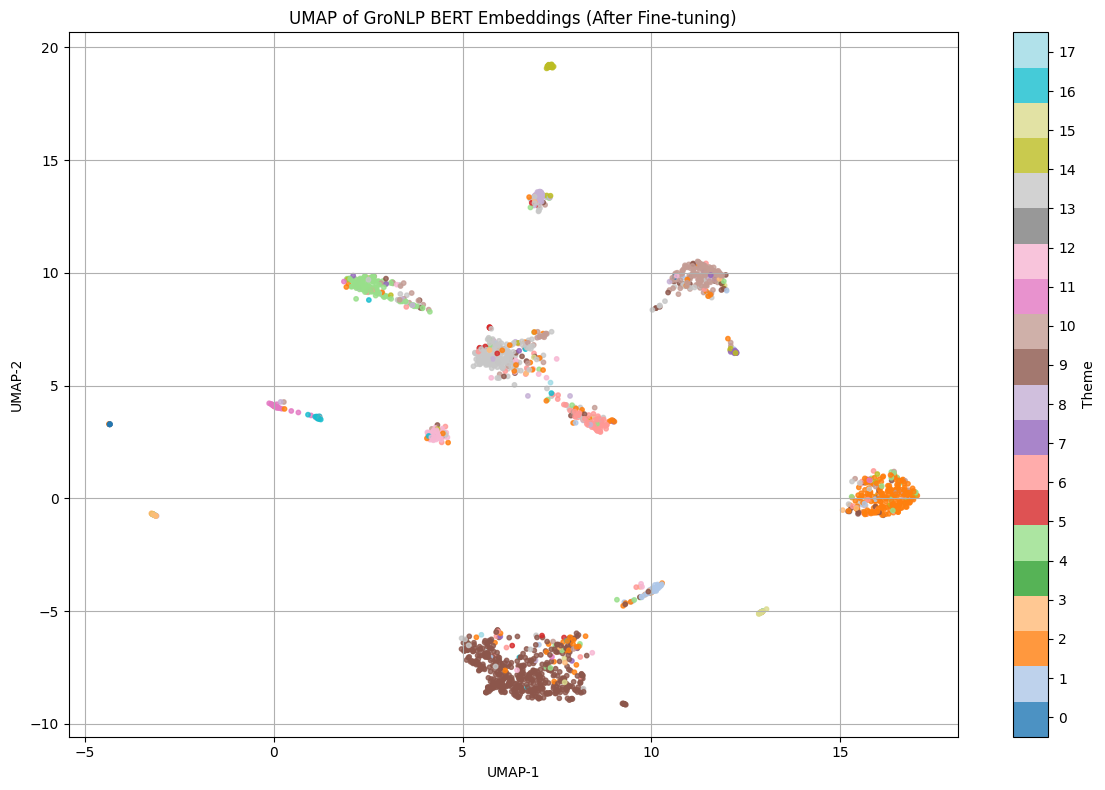

In [14]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# Sample 2000 rows for UMAP
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# Generate embeddings
embeddings = []
print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Encode labels for plotting
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

# Plot UMAP
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of GroNLP BERT Embeddings (After Fine-tuning)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb = plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
tick_labels = [id_to_theme[i] for i in le.classes_]
cb.ax.set_yticklabels(tick_labels)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# # ✅ Load model and tokenizer
# model = AutoModelForSequenceClassification.from_pretrained(save_path)
# tokenizer = AutoTokenizer.from_pretrained(save_path)
# model.eval()  # Make sure model is in eval mode

# ✅ Define SHAP-compatible prediction function
def predict(texts):
    # Convert to Python list of strings if SHAP passed a NumPy array
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# ✅ Initialize masker and explainer
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict, masker, output_names=list(id_to_theme.values()))

# ✅ Sample a few texts to explain (just the text column as list)
sample_df = df[["text", "true_label"]].sample(n=min(2000, len(df)), random_state=42)
sample_df.rename(columns={"text": "clean_text", "true_label": "theme_id"}, inplace=True)

# ✅ Extract list of strings for SHAP
sample_texts = sample_df["clean_text"].tolist()[:5]  # First 5 texts only

# ✅ Generate SHAP values
shap_values = explainer(sample_texts)

# ✅ Visualize the explanation for the first text
shap.plots.text(shap_values[0])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
shap.plots.text(shap_values[1])

In [ ]:
for i in range(0,4):
    shap.plots.text(shap_values[i])

In [16]:
import sys
sys.path.append(r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\EvaluateModels\TransSHAP\explainers")  # adapt this

from IME_for_text import IMExplainer
from visualize_explanations import joint_visualization
import torch
import numpy as np



In [17]:
from IME_for_text import IMExplainer
from visualize_explanations import joint_visualization
import torch
import numpy as np

# ✅ Wrap model to extract logits
class LogitsOnlyWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs).logits

wrapped_model = LogitsOnlyWrapper(model)


In [18]:
# 1. Load your test sentence
sentence_list = ["Welke aspecten van het uitwerken van deze maatregel vallen onder respectievelijk de bevoegdheid van minister Diependaele en van minister Peeters?",
                 "Denkt de minister eraan om de universiteiten en hogescholen hierover te sensibiliseren?",
                 "Hoeveel boetes voor ongeoorloofd smartphonegebruik tijdens het rijden met de fiets werden er uitgeschreven tussen 2019 en 2023 in Vlaanderen?",
                 "Wat zijn de voornaamste redenen waarom een aanvraag werd geweigerd?",
                 "Kan de minister - zeer summier - per actie van het VAPA de laatste stand van zaken geven?",
                "Wordt de expertise van het VIKZ ook meegenomen in het onderzoek?"]

In [25]:

# 2. Build a representative background from training
background_data = sample_df["clean_text"].sample(n=100, random_state=1).tolist()

# 3. Initialize TranSHAP
ime = IMExplainer(
    model=wrapped_model,
    data=background_data,  # 👈 Background only!
    size_bg_data=10,
    n_iter=15,
    err=0.2,
    tokenizer=tokenizer,
    bag_of_words=list(tokenizer.get_vocab().keys())
)

# ✅ Safe explanation call (avoid shape crash)
def safe_explain(ime_obj, input_texts):
    try:
        return ime_obj.explain(input_texts)
    except ValueError as e:
        if "inhomogeneous shape" in str(e):
            print("⚠️ Skipping feature_importance calculation due to token length mismatch.")
            return ime_obj.IME_text(input_texts), ime_obj.tweets, [
                ime_obj.softmax(wrapped_model(torch.tensor([ime_obj.text_to_ids(text)])).detach().numpy())[0]
                for text in input_texts
            ]
        else:
            raise

# ✅ Run the explanation
contributions, tokenized_texts, predictions = safe_explain(ime, sentence_list)

04-May-25 22:17:36 - Calculating expected value from train data
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.97it/s]
04-May-25 22:17:36 - Example 1/6 start


feature 1/21
needed [10. 15. 42.  3.  9.  8. 23.  7. 14. 19. 13. 29.  3. 20. 35.  6. 73. 21.] n 15
needed [ 7. 10. 26.  4. 12.  5. 20.  5. 32. 12.  8. 16.  3. 14. 38.  5. 39. 13.] n 30
needed [20.  9. 34.  6. 43.  9. 23.  5. 31. 31. 17. 19.  3. 18. 28.  4. 29. 17.] n 45
feature 2/21
needed [ 8. 47. 87. 19. 31.  8. 49.  5. 25. 11. 92. 16.  4. 20. 28. 13.  6. 14.] n 15
needed [ 11.  32.  71.  32.  62.  12.  54.   5.  25.  21. 247.  25.  20.  31.
  40.  23.  10.  30.] n 30
needed [ 11.  23.  61.  24.  52.  12.  53.   5.  29.  20. 170.  25.  15.  31.
  32.  17.   9.  31.] n 45
needed [ 15.  21.  62.  22.  46.  12.  48.   7.  28.  24. 136.  25.  13.  35.
  41.  16.  13.  30.] n 60
needed [ 14.  22.  85.  24.  69.  61.  72.  10.  39.  25. 113.  27.  12. 105.
  49.  16.  16.  28.] n 75
needed [ 13.  21. 119.  22.  80.  53.  77.  11.  46.  28.  98.  32.  11. 107.
  56.  16.  20.  42.] n 90
needed [ 14.  18. 110.  21.  76.  46.  71.  10.  46.  34.  89.  30.  10. 104.
  53.  15.  19.  39.] n 105

04-May-25 22:19:54 - Example 1/6 stop
04-May-25 22:19:54 - Example 2/6 start


needed [12.  7. 76. 50. 36. 11. 66.  6. 66. 30. 20. 21.  5. 27. 33. 13. 28. 18.] n 90
feature 1/13
needed [  5.   3.  16.  29. 117.   4.  13.   8.  14.   8.  11.  10.   4.  29.
  57.   6.   7.  11.] n 15
needed [ 7.  8. 32. 23. 70.  4. 66. 11. 22. 25. 11.  9.  6. 96. 64. 13.  8. 11.] n 30
needed [ 6.  7. 27. 18. 50.  5. 47.  8. 17. 18. 13.  7.  5. 71. 50. 10.  6. 11.] n 45
needed [11.  7. 34. 16. 55.  5. 58.  8. 17. 15. 15.  6.  5. 83. 47.  8.  8. 10.] n 60
needed [14.  6. 50. 20. 46.  5. 50.  7. 22. 13. 18.  6.  4. 85. 43.  8.  8. 10.] n 75
needed [13.  6. 46. 18. 46.  5. 44.  7. 23. 13. 29.  6.  4. 93. 42.  7.  9. 13.] n 90
needed [ 12.   7.  44.  24.  44.   6.  42.   8.  23.  11.  29.   7.   8. 120.
  56.  12.   9.  12.] n 105
needed [ 12.   7.  39.  25.  47.   7.  39.   8.  21.  14.  26.   7.   7. 111.
  52.  13.   9.  13.] n 120
feature 2/13
needed [76.  7. 33. 22. 72.  5. 61.  6. 47. 24. 24. 10.  6. 90. 73.  5. 16. 53.] n 15
needed [ 64.   6.  71.  22. 112.  11.  86.   9.  91.  5

04-May-25 22:21:53 - Example 2/6 stop
04-May-25 22:21:53 - Example 3/6 start


needed [ 31.  24. 106.  18.  47.  13.  77.  15.  51.  38.  45.  21.  15. 150.
  92.  12.  20.  34.] n 165
feature 1/21
needed [17. 17. 34. 10. 38. 12. 33.  7. 18. 42. 17. 11.  3. 17. 20.  6. 10. 22.] n 15
needed [11. 10. 26.  8. 88. 10. 23.  5. 15. 56. 14. 20.  2. 22. 14.  5.  9. 19.] n 30
needed [13.  9. 30.  9. 82. 17. 25.  6. 20. 64. 11. 14.  3. 18. 27. 13. 12. 21.] n 45
needed [12. 12. 31.  8. 66. 95. 48.  7. 22. 83. 20. 14.  3. 37. 25. 11. 13. 18.] n 60
needed [11. 11. 35.  7. 57. 77. 40. 11. 21. 70. 20. 13.  3. 35. 22.  9. 12. 20.] n 75
needed [11. 10. 38.  9. 54. 66. 39. 12. 21. 60. 20. 12.  3. 37. 19.  9. 11. 17.] n 90
feature 2/21
needed [ 52.  12. 136.  18. 122.  34. 138.  18. 338. 134. 135.  25.  16. 239.
  64.  30.  24.  47.] n 15
needed [ 39.  18. 283.  58. 141.  25. 127.  16. 276. 226.  94.  88.  20. 148.
  54.  21.  26.  44.] n 30
needed [ 42.  44. 266.  51. 221.  23. 145.  12. 199. 297.  80.  92.  21. 123.
  60.  19.  54.  36.] n 45
needed [ 38.  37. 244.  45. 192.  24.

04-May-25 22:24:43 - Example 3/6 stop
04-May-25 22:24:43 - Example 4/6 start


needed [ 14.  10.  92.  19.  92.   8.  77.  10.  42. 145.  33.  24.   8.  62.
  32.  13.  13.  28.] n 165
feature 1/11
needed [ 14.  12.  36.  12.  40. 124.  80.  11.  36.  17.  17.  27.   4.  37.
  73.   9.  13.  15.] n 15
needed [26. 13. 39. 19. 36. 65. 77.  9. 27. 16. 35. 18.  4. 26. 58. 11. 10. 21.] n 30
needed [19. 10. 38. 14. 32. 45. 55.  7. 30. 15. 29. 14.  4. 19. 47. 10.  9. 17.] n 45
needed [18. 12. 91. 13. 81. 35. 55.  9. 39. 16. 57. 26. 11. 29. 53. 11. 10. 28.] n 60
needed [ 15.  11. 105.  12.  77.  31.  45.   9.  42.  18.  68.  23.  10.  26.
  51.  13.  10.  28.] n 75
needed [14. 10. 96. 11. 78. 26. 59.  9. 62. 16. 64. 21.  9. 28. 53. 11. 11. 25.] n 90
needed [12. 10. 85. 10. 70. 23. 53.  8. 55. 15. 55. 19.  8. 26. 49. 10. 10. 22.] n 105
feature 2/11
needed [ 31.   6. 128.  25. 221.  11.  71.  10.  97. 269. 253.  32.  11.  38.
 344.  23.  18.  39.] n 15
needed [ 64.  17. 337.  27. 359.  14.  66.  18.  81. 167. 199.  52.  14. 106.
 281.  18.  65.  47.] n 30
needed [ 55.  17.

04-May-25 22:26:06 - Example 4/6 stop
04-May-25 22:26:06 - Example 5/6 start


needed [ 31.  25. 217.  45. 222.  42. 110.  21. 110.  56. 148.  43.  26. 185.
 289.  32.  50.  54.] n 300
feature 1/19
needed [ 19.  26. 255.  13. 157.   3.  41.   8.  14.  22.  23.  38.   7.  57.
  45.   3.  11.  62.] n 15
needed [ 15.  18. 189.  11. 157.   7.  39.  10.  72.  28.  92.  38.  14.  82.
  29.   8.  12.  40.] n 30
needed [ 12.  16. 181.  10. 133.   7.  36.   9.  55.  27.  85.  42.  11.  62.
  30.   7.  11.  36.] n 45
needed [ 10.  14. 151.  11. 113.   6.  29.   8.  48.  23.  73.  37.  10.  56.
  31.   6.  10.  31.] n 60
needed [ 11.  13. 127.  10. 139.   6.  32.   8.  42.  22.  61.  38.  10.  81.
  28.   7.  16.  27.] n 75
needed [ 11.  11. 113.  11. 125.   6.  29.   8.  38.  21.  55.  38.  10.  75.
  27.   6.  15.  25.] n 90
needed [ 11.  10.  99.  10. 111.   5.  28.   8.  36.  19.  48.  33.   9.  67.
  26.   6.  13.  24.] n 105
needed [10.  9. 90.  9. 99.  5. 26.  7. 32. 20. 43. 30.  8. 60. 27.  6. 12. 21.] n 120
feature 2/19
needed [12. 15. 89. 14. 53. 12. 56.  7. 22. 1

04-May-25 22:28:26 - Example 5/6 stop
04-May-25 22:28:26 - Example 6/6 start


needed [12. 17. 86. 11. 69. 71. 61.  9. 29. 19. 51. 18.  5. 89. 67.  9. 12. 20.] n 90
feature 1/12
needed [  2.   5. 143.   2.  14.   3.  10.   2.  45.   5. 167.   5.   3.  11.
  83.   9.   3.   6.] n 15
needed [  9.   4.  84.  17.  16.   3.   8.   2.  27.   8. 107.   5.   3.  13.
  50.   6.   5.   6.] n 30
needed [ 7.  3. 64. 14. 43.  3.  8.  2. 20.  8. 81.  5.  3. 12. 65.  8.  4.  7.] n 45
needed [ 8.  4. 57. 13. 35.  5. 14.  4. 17. 11. 71.  7.  5. 12. 61.  7.  4.  7.] n 60
needed [ 7.  5. 59. 11. 52.  6. 17.  4. 22.  9. 59.  8.  5. 12. 58.  6.  4.  7.] n 75
feature 2/12
needed [ 21.   8. 126.  17.  38.   6.  23.   5.  36.  15.  79.  16.   6.  22.
  18.   8.  19.  45.] n 15
needed [ 15.   7. 106.  14.  35.   6.  19.   6.  31.  15.  62.  74.  10.  19.
  20.  19.  14.  29.] n 30
needed [ 28.  19. 101.  21.  73.  16.  38.   8.  70.  17.  99.  61.   9.  35.
  41.  27.  15.  32.] n 45
needed [22. 16. 88. 17. 91. 14. 52.  7. 55. 16. 86. 49.  8. 30. 37. 22. 13. 35.] n 60
needed [ 20.  14. 1

04-May-25 22:29:33 - Example 6/6 stop


needed [ 31.   9.  95.  20.  57.  22.  50.   8.  24.  18. 132.  18.   8.  38.
  55.   8.  12.  24.] n 135


04-May-25 22:29:34 - Example 1/6 start


⚠️ Skipping feature_importance calculation due to token length mismatch.
feature 1/21
needed [ 3.  1. 22.  3.  8.  2.  9.  2.  7.  4.  7. 10.  2.  4. 10.  4.  7.  6.] n 15
needed [ 4.  2. 26.  5. 11.  4. 12.  3. 22.  5.  7. 11.  4. 14. 10.  7.  9.  8.] n 30
feature 2/21
needed [ 17.  27. 103.  12.  99.  20. 107.   8.  27.  58.  33.  82.  15. 133.
  69.  13.  25.  69.] n 15
needed [ 13.  20.  80.  11.  85.  17.  94.  13.  20.  38.  19.  72.  10. 155.
  70.  17.  18.  43.] n 30
needed [ 10.  14.  72.  30.  86.  14.  96.   9.  34.  31.  16.  56.  10. 117.
 106.  14.  20.  37.] n 45
needed [ 13.  13.  90.  27.  79.  13.  89.  22.  42.  27.  35.  51.  10. 125.
  94.  13.  20.  39.] n 60
needed [ 12.  13. 108.  27.  70.  14.  77.  19.  45.  29.  38.  51.  10. 109.
  80.  15.  22.  38.] n 75
needed [ 12.  12. 103.  47.  66.  12.  79.  18.  46.  27.  37.  47.  10.  97.
  79.  16.  22.  39.] n 90
needed [13. 12. 92. 47. 71. 18. 75. 18. 43. 29. 38. 43. 10. 89. 84. 15. 23. 38.] n 105
feature 3/21

04-May-25 22:31:57 - Example 1/6 stop
04-May-25 22:31:57 - Example 2/6 start


needed [17.  6. 85. 14. 70.  9. 71. 42. 43. 25. 28. 19. 12. 63. 54. 15. 24. 30.] n 105
feature 1/13
needed [  4.  11. 105.  26.  27.   5.  20.   8.  97.  25.  39.  11.   8.  42.
  35.   6.  26.  46.] n 15
needed [  7.   9. 130.  20.  31.   8.  18.   8.  61.  16.  24.   7.  11.  38.
  87.  12.  17.  29.] n 30
needed [ 7.  7. 98. 21. 33.  6. 17. 10. 55. 16. 21.  9.  9. 48. 66. 10. 14. 24.] n 45
needed [ 8.  7. 81. 18. 32.  7. 16.  9. 47. 15. 20.  7.  7. 40. 56.  8. 12. 20.] n 60
needed [ 10.  23.  69.  31.  29.   7.  48.   9.  44.  20.  18.   8.  11.  40.
 101.   6.  12.  25.] n 75
needed [10. 27. 66. 30. 38.  9. 45.  9. 41. 20. 18.  9. 10. 35. 92. 10. 12. 24.] n 90
needed [10. 24. 61. 27. 37.  9. 39.  9. 39. 19. 16.  9.  9. 35. 89.  9. 12. 22.] n 105
feature 2/13
needed [ 8.  4. 19. 13. 31.  3. 20.  6.  9. 10. 23.  8.  4. 32. 41.  3. 18. 36.] n 15
needed [ 8. 14. 26. 23. 62. 13. 26.  7. 21. 12. 17. 10.  6. 39. 35.  6. 16. 30.] n 30
needed [ 17.  10.  75.  20.  59.  10.  81.   7.  18.  1

04-May-25 22:34:03 - Example 2/6 stop
04-May-25 22:34:03 - Example 3/6 start


needed [ 20.  15.  81.  21.  68.  17.  50.  15.  37.  53.  62.  13.  10. 171.
  91.  10.  19.  29.] n 195
feature 1/21
needed [10.  2. 59.  5.  5.  3. 41.  4.  7. 35. 11.  9.  4. 26. 15.  3. 80.  5.] n 15
needed [ 9.  6. 40.  5. 18. 11. 31.  4.  8. 31.  9.  8.  5. 25. 14.  6. 43.  4.] n 30
needed [ 9. 28. 45.  6. 35.  9. 32.  4. 11. 28. 23.  8.  7. 22. 16.  6. 36. 13.] n 45
needed [ 9. 22. 54.  9. 49.  9. 30.  6. 14. 55. 24.  9.  7. 65. 14.  6. 37. 14.] n 60
needed [15. 19. 50. 11. 49. 10. 46. 11. 22. 59. 26. 14.  6. 62. 14.  7. 33. 14.] n 75
feature 2/21
needed [ 15.  10. 499.  17.  54.  22. 152.  12.  21. 324. 117.  60.  29.  83.
  29.   9.  26.  61.] n 15
needed [ 15.  30. 345.  19. 115.  27. 133.  10.  30. 372. 121.  46.  25.  97.
  60.  11.  26.  64.] n 30
needed [ 23.  63. 279.  28.  99.  22. 193.  15.  48. 336. 161.  61.  24.  91.
  74.  24.  47.  72.] n 45
needed [ 19.  49. 224.  28.  84.  21. 160.  14.  38. 269. 126.  52.  21.  84.
  65.  19.  41.  59.] n 60
needed [ 24.  48. 

04-May-25 22:36:44 - Example 3/6 stop
04-May-25 22:36:44 - Example 4/6 start


needed [ 15.  15. 131.  17.  72.  11. 112.  16. 129.  72.  22.  20.   9.  41.
  22.  11.  14.  27.] n 135
feature 1/11
needed [16. 97. 91.  8. 67.  8. 41.  7. 13. 30. 76. 27.  6. 32. 89. 10. 18. 25.] n 15
needed [ 14.  60.  71.  10. 113.  10. 142.  13.  30.  38.  41.  18.   7.  57.
  68.   9.  16.  16.] n 30
needed [ 15.  44.  87.  12. 152.   8. 104.  11.  28.  28.  70.  21.  12.  48.
  50.  12.  12.  16.] n 45
needed [ 15.  36.  83.  13. 119.   8.  87.  12.  28.  26.  67.  21.  12.  52.
  56.  10.  10.  17.] n 60
needed [ 14.  32. 120.  12. 108.   7.  73.  12.  25.  25. 101.  21.  15.  68.
  54.  12.  12.  18.] n 75
needed [ 14.  28. 108.  11. 138.   7.  72.  11.  34.  23. 120.  19.  15.  62.
  59.  11.  12.  17.] n 90
needed [ 14.  27. 111.  10. 126.   8.  75.  11.  60.  21. 105.  19.  14.  59.
  60.  10.  13.  16.] n 105
needed [ 13.  24. 101.  10. 115.   8.  78.  10.  59.  19.  97.  19.  13.  54.
  56.  10.  13.  15.] n 120
feature 2/11
needed [  9.  18. 130.  57.  56.  27.  82.  1

04-May-25 22:38:03 - Example 4/6 stop
04-May-25 22:38:03 - Example 5/6 start


needed [ 33.  52. 234.  39. 198.  44. 126.  24.  94.  67. 124.  34.  33. 120.
 195.  25.  58.  51.] n 240
feature 1/19
needed [ 19.   7.  20.  10.  35.  13.  62.  15.  12.   3.   9.  10.   7. 108.
  52.  19.  84.   6.] n 15
needed [13.  7. 26. 11. 97.  9. 63. 12. 31.  5. 10.  9.  6. 68. 37. 12. 48.  6.] n 30
needed [14.  8. 54. 10. 82. 12. 92. 14. 40. 18. 14. 14.  8. 74. 39. 26. 36. 11.] n 45
needed [14.  8. 57. 10. 69. 12. 86. 12. 39. 17. 15. 14.  8. 63. 41. 23. 32. 13.] n 60
needed [13.  7. 65. 12. 79. 20. 87. 11. 49. 20. 24. 19.  8. 58. 45. 20. 27. 25.] n 75
needed [13.  7. 78. 11. 69. 19. 82. 10. 69. 18. 28. 18.  7. 58. 43. 19. 27. 33.] n 90
feature 2/19
needed [ 20.  17. 156.  47.  85.   4.  90.  11.  34. 134.  34. 157.  11.  39.
  45.  11.  24.  40.] n 15
needed [ 32. 100. 201.  34. 196.   9. 168.  18.  39. 113.  52.  93.  22. 110.
  40.  28.  22.  68.] n 30
needed [ 47.  71. 210.  36. 213.  23. 193.  23.  42. 105.  79.  68.  24. 224.
 181.  23.  29.  53.] n 45
needed [ 36.  56. 

04-May-25 22:40:28 - Example 5/6 stop
04-May-25 22:40:28 - Example 6/6 start


needed [ 17.  10.  87.  30. 116.   9. 103.  11.  33.  25.  47.  18.   9.  90.
 106.   9.  15.  23.] n 135
feature 1/12
needed [12.  1. 45. 12. 60. 10. 42.  7. 27.  9. 71.  4.  4. 50. 32.  5.  2.  8.] n 15
needed [ 8.  1. 71.  9. 83.  7. 30.  5. 18.  7. 70.  4.  4. 32. 20.  5.  3.  9.] n 30
needed [  7.  10. 132.  11.  88.  18.  26.   8.  17.   7. 159.   8.   7.  37.
  20.   8.   5.   8.] n 45
needed [  7.  15. 149.  10.  70.  14.  29.  13.  18.   7. 127.   8.  10.  33.
  19.  10.   4.  12.] n 60
needed [ 12.  12. 131.   9.  63.  13.  26.  12.  27.   9. 115.   8.   8.  29.
  17.  10.   4.  11.] n 75
needed [ 17.  11. 121.   9.  56.  11.  26.  12.  31.  10. 103.   8.   7.  40.
  18.   9.   5.  16.] n 90
needed [ 17.  10. 120.  11.  50.  29.  32.  11.  36.  22.  95.   8.   8.  58.
  26.  18.   6.  17.] n 105
needed [ 15.   9. 109.  12.  50.  26.  37.  10.  32.  20. 106.   8.   7.  73.
  24.  17.   6.  16.] n 120
feature 2/12
needed [ 19.  54.  65.  14.  42.  13. 100.  11.  20.  43.  65.  

04-May-25 22:41:45 - Example 6/6 stop


needed [ 14.   9.  87.  37.  92.  29.  31.   6.  27.  19. 130.  14.   8.  61.
  58.  22.  11.  22.] n 150


DONE figures/our_vis_0


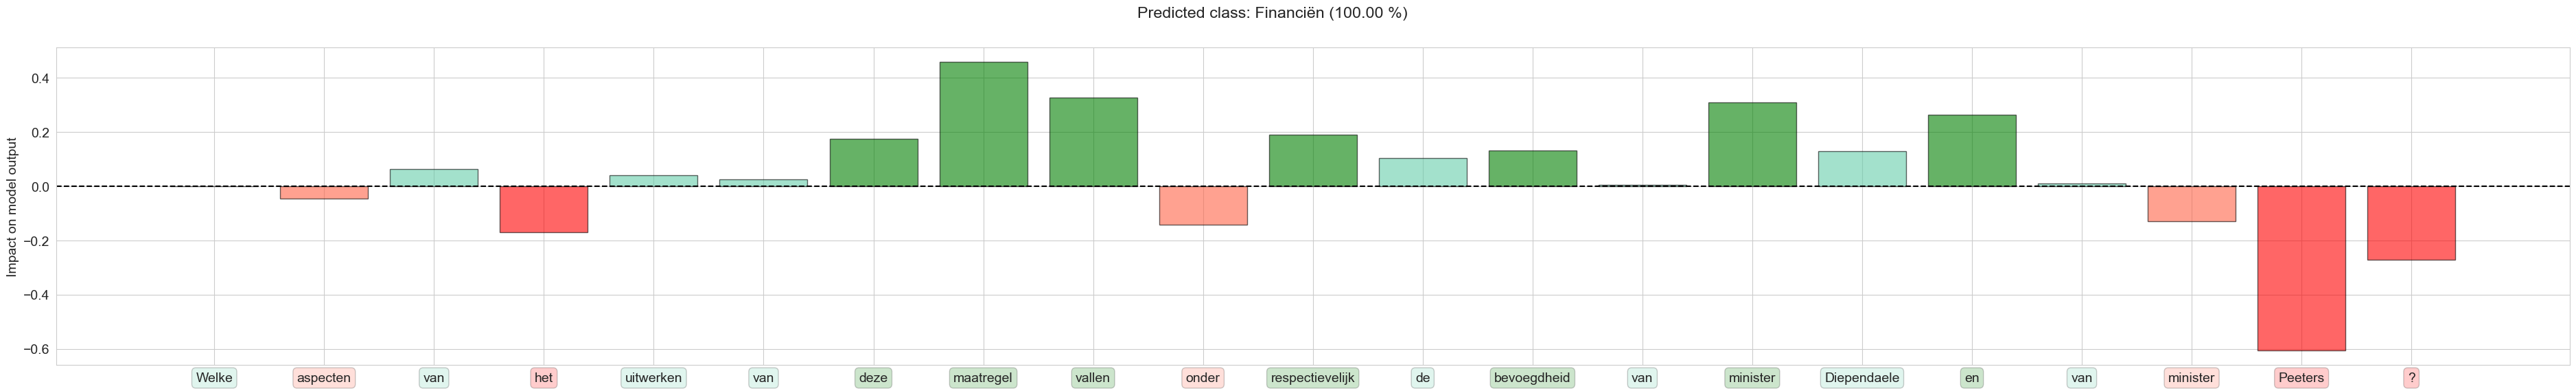

In [27]:
# 5. Visualize result
joint_visualization(
    tokenized_texts[0],
    contributions[0][:, np.argmax(predictions[0])],
    class_to_explain=id_to_theme[np.argmax(predictions[0])],
    pred=np.max(predictions[0]),
    i=0
)

DONE figures/our_vis_0
DONE figures/our_vis_1
DONE figures/our_vis_2
DONE figures/our_vis_3
DONE figures/our_vis_4
DONE figures/our_vis_5


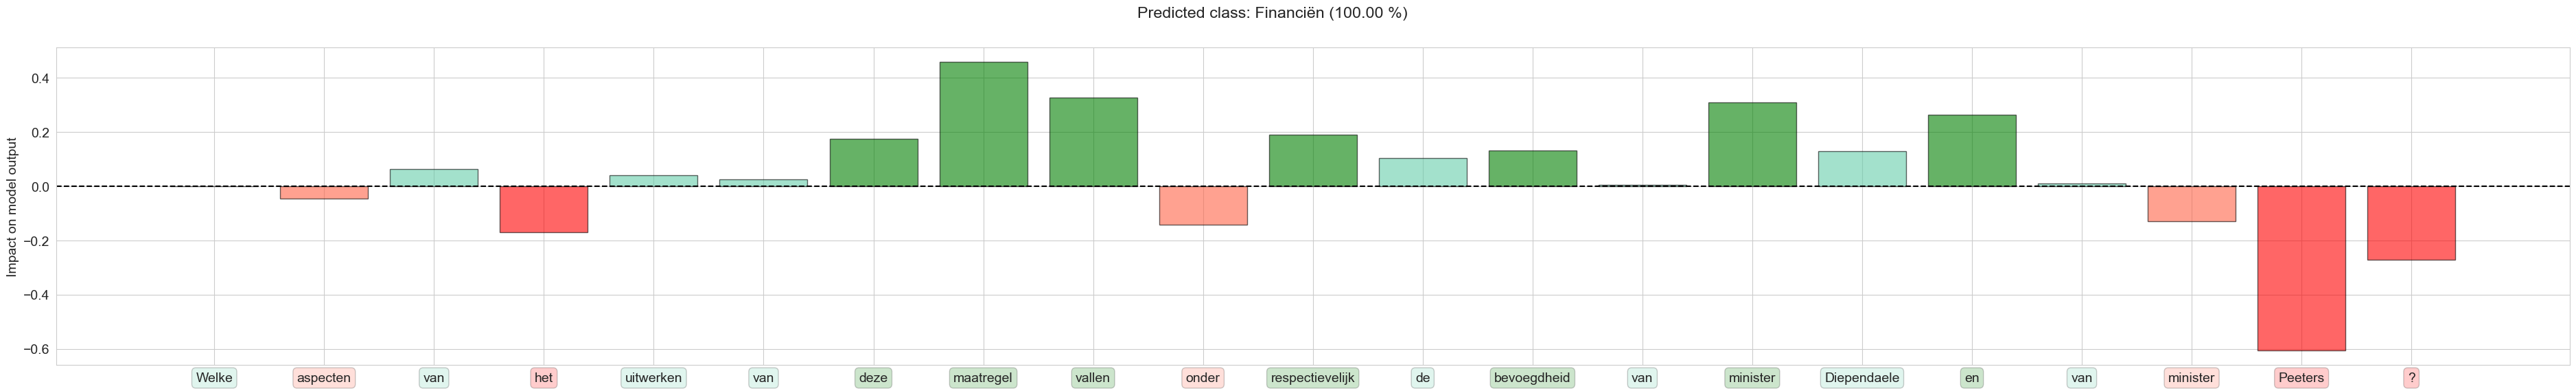

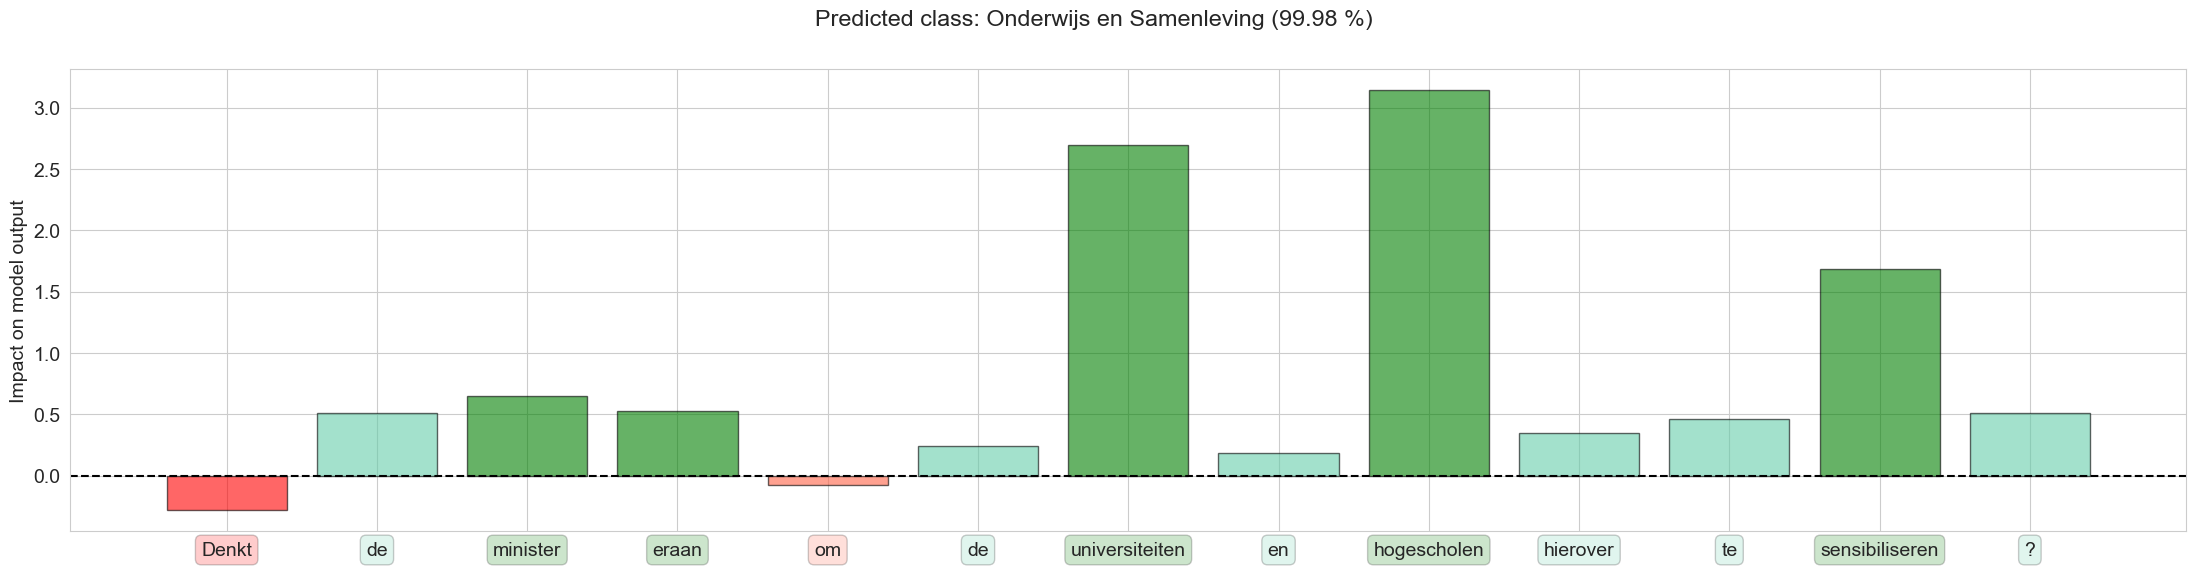

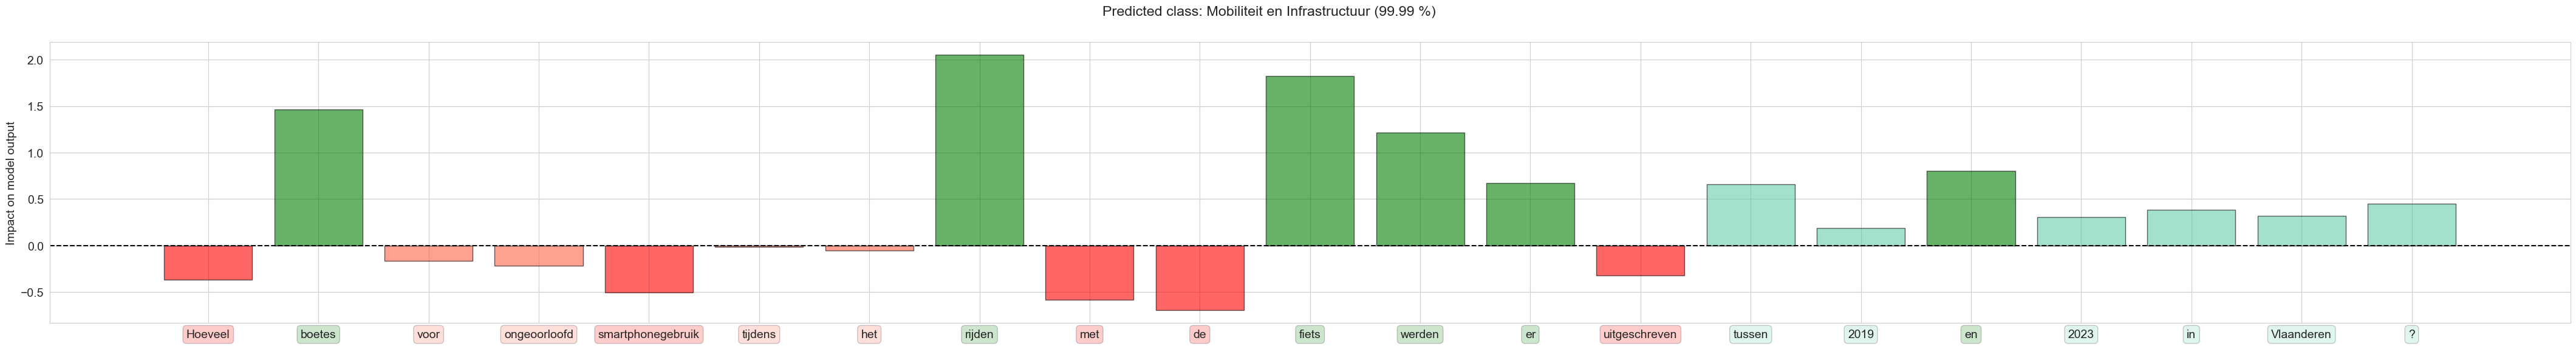

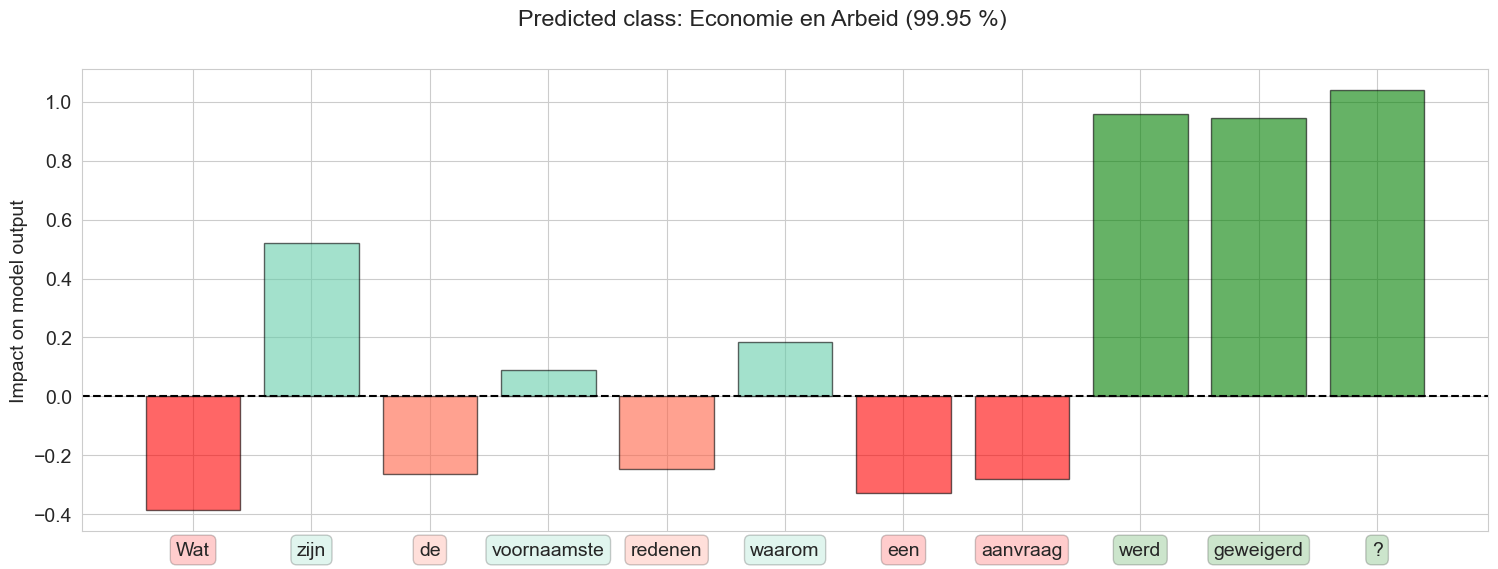

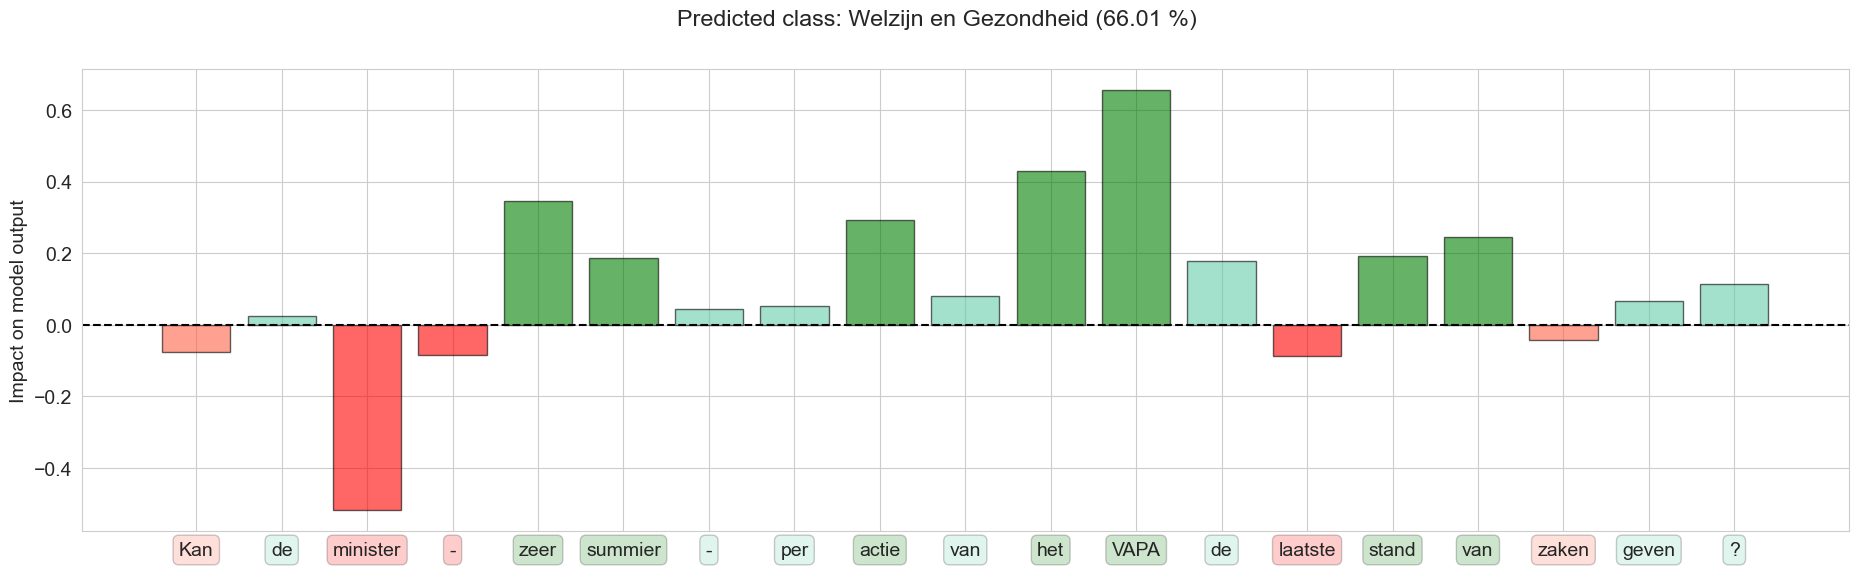

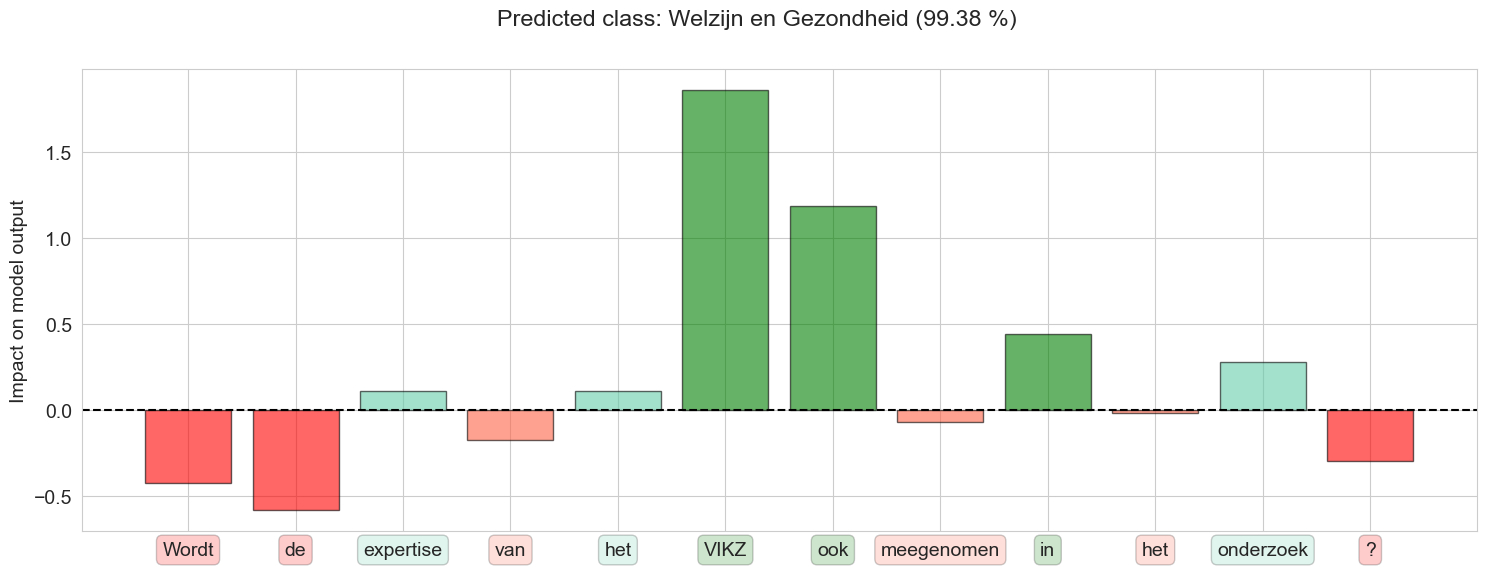

In [28]:
# 5. Visualize result
for z in range(6):
    joint_visualization(
        tokenized_texts[z],
        contributions[z][:, np.argmax(predictions[z])],
        class_to_explain=id_to_theme[np.argmax(predictions[z])],
        pred=np.max(predictions[z]),
        i=z
    )

In [ ]:
from bertviz import head_view
import torch

from IPython.core.display import display, HTML
display(HTML("<script src='https://requirejs.org/docs/release/2.3.6/minified/require.js'></script>"))


model.eval()  # Make sure model is in evaluation mode

# ✅ Input sentence to visualize
sentence = "Kunnen de Vlaamse minister-president en de Vlaamse minister van Omgeving verduidelijken waarom deze verkoopmogelijkheid niet door hen in hun voorstel werd opgenomen met betrekking tot bestaande 70 en 150 kV hoogspanningslijnen die zullen omgevormd worden naar 380 kV hoogspanningslijnen?"

# ✅ Tokenize input
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)

# ✅ Forward pass to extract attentions
with torch.no_grad():
    outputs = model(**inputs)
    attention = outputs.attentions  # Tuple of attention matrices, one per layer

# ✅ Convert tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# ✅ Launch interactive attention view (in Jupyter)
head_view(attention, tokens)